In [1]:
import os
import datetime
import math
from datetime import date
import time
from collections import Counter
from collections import defaultdict
from itertools import product
from math import log

import pickle
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

#%matplotlib inline
sns.set()

# MODELING PROCESS

The modeling process will consist of the following phases:

1. Normalize data
2. Build model
3. Compute cross-validation accuracy
4. Tune model
5. Repeat
6. **Report accuracy on new data**

In [2]:
def initial_setup():
    """Create Initial setup of directories variables, and dataframe vars to use.
    Returns:
        A tuple containing:
            - datadir....Absolute Path to the data directory of the project.
            - dirname....Absolute Path of directory that contains this file.
            - imagesdir..Absolute path of directory that contains the images.
            - modelsdir..Absolute path of directory that contains the models.
    """
    dirname = os.path.dirname(os.path.abspath('__file__'))
    datadir =  os.path.join(
                os.path.abspath(os.path.join(os.path.join(dirname, os.pardir), os.pardir)), 
                'data'
            )
    imagesdir =  os.path.join(os.path.abspath(os.path.join(dirname, os.pardir)), 'images')
    modelsdir = os.path.join(datadir, 'models')
    return dirname, datadir, imagesdir, modelsdir


def read_from_disk(filename):
    """Read a dataframe from a filename in disk.
    Args:
        filename....Path to the file.
    Returns:
        A pandas dataframe.
    """
    return pickle.load(open(filename, 'rb'))


def store_model(model, filename):
    """Store model using pickle.
    Args:
        model...,,,,ML model to store.
        filename....Path to the file to store the datafram in.
    Returns:
        Nothing.
    """
    pickl = {'model': model}
    pickle.dump(pickl, open(filename + ".p", "wb"))

In [3]:
# 0 - Initial directories and colnames set up
print("Step 0: Initial directories and colnames set up")
dirname, datadir, imagesdir, modelsdir = initial_setup()
print("Directory of this file is {}".format(dirname))
print("Data directory is {}".format(datadir))
print("Images directory is {}".format(imagesdir))
print("Models directory is {}".format(modelsdir))

Step 0: Initial directories and colnames set up
Directory of this file is /home/agericke/crowdfunding_ml/src/modeling
Data directory is /home/agericke/crowdfunding_ml/data
Images directory is /home/agericke/crowdfunding_ml/src/images
Models directory is /home/agericke/crowdfunding_ml/data/models


##  0. Load data and select variables.

In [4]:
df = read_from_disk(os.path.join(datadir, 'data_cleaned.pkl'))
df.head(10)

,staff_pick,result,goal_usd,pledged_usd,main_category,state,ln(goal_usd),goal_usd_bin,duration_in_days_bin,weekday_launch,weekend_launch,month_launch,num_competitors,num_competitors_bin,num_competitors_staffpick
launched_at,,,,,,,,,,,,,,,
2009-04-28 11:55:41,True,1,3000.0,3329.00,journalism,NY,8.006368,"(0.0, 40000.0]","(0.0, 29.0]",Tuesday,False,4,1.0,"(0.0, 10.0]",1.0
2009-04-29 03:26:32,False,0,300.0,15.00,music,IL,5.703782,"(0.0, 40000.0]","(0.0, 29.0]",Wednesday,False,4,1.0,"(0.0, 10.0]",0.0
2009-04-29 20:08:13,False,0,640.0,41.00,design,NY,6.461468,"(0.0, 40000.0]","(45.0, inf]",Wednesday,False,4,1.0,"(0.0, 10.0]",0.0
2009-04-29 21:11:15,True,1,500.0,1820.00,technology,NY,6.214608,"(0.0, 40000.0]","(45.0, inf]",Wednesday,False,4,1.0,"(0.0, 10.0]",1.0
2009-04-29 23:32:55,False,1,500.0,501.66,film-&-video,IN,6.214608,"(0.0, 40000.0]","(29.0, 45.0]",Wednesday,False,4,1.0,"(0.0, 10.0]",0.0
2009-04-30 20:22:43,True,1,6000.0,6575.00,theater,NY,8.699515,"(0.0, 40000.0]","(29.0, 45.0]",Thursday,False,4,1.0,"(0.0, 10.0]",1.0
2009-04-30 20:23:22,False,1,10000.0,10145.00,theater,NY,9.210340,"(0.0, 40000.0]","(45.0, inf]",Thursday,False,4,2.0,"(0.0, 10.0]",1.0
2009-05-01 03:06:19,True,1,500.0,575.00,theater,VA,6.214608,"(0.0, 40000.0]","(29.0, 45.0]",Friday,False,5,1.0,"(0.0, 10.0]",1.0
2009-05-01 12:22:21,False,0,2000.0,25.00,art,NY,7.600902,"(0.0, 40000.0]","(29.0, 45.0]",Friday,False,5,1.0,"(0.0, 10.0]",0.0


In [5]:
columns = ['staff_pick', 'result', 'ln(goal_usd)', 'main_category', 'state', 'duration_in_days_bin', 
           'weekday_launch', 'month_launch', 'num_competitors_bin']
df = df[columns].copy()

## 1. Standardize data and Dummy Variables

First of all lets standardize only numeric columns of the data.

In [6]:
from pandas.api.types import is_numeric_dtype

y = df['result']
X = df.drop('result', axis=1)
num_cols = X.columns[X.dtypes.apply(lambda col: np.all([is_numeric_dtype(col),  col != 'bool']))]

In [7]:
scaler = preprocessing.StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
X['staff_pick'] = X['staff_pick'].astype('int')

In [9]:
X = pd.get_dummies(X, drop_first=True)

Stratified splitting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##  2. Models

###  2.0 NIR (No Informaiton Rate)

In [29]:
nir = np.mean(y)
nir

0.5531897274524621

### 2.1 Gaussian Naive Bayes

In [30]:
gnb_scikit = GaussianNB()

In [31]:
gnb_scikit.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [32]:
y_test_pred = gnb_scikit.predict(X_test)
y_train_pred = gnb_scikit.predict(X_train)

In [38]:
y_test.head(10).to_numpy().tolist()

[1, 1, 0, 1, 1, 1, 1, 1, 1, 0]

In [17]:
print('accuracy on training data={:.10f}'.format(accuracy_score(y_train_pred, y_train)))
print('accuracy on test data={:.10f}'.format(accuracy_score(y_test_pred, y_test)))

accuracy on training data=0.6518751900
accuracy on test data=0.6486038869


For a Gaussian Naive Bayes classificator we will need to compute:

1. P(y) - Prior probabilities
2. P(x|y)
3. P(y|x) - Posterior probabilities

In [18]:
class GaussianNaiveBayes:
    """Naive Bayes text categorization model
    """

    def __init__(self, unique_classes=[0]):
        self.classes = np.array(unique_classes)
        
    
    def fit(self, X, y):

        self.examples = X
        self.labels = y

        self.prior_prob = X.groupby(y).apply(lambda x: float(len(x)) / float(X.shape[0])).to_numpy()

        # Calculate per column means
        self.means = X.groupby(y).aggregate(np.mean).to_numpy()
        self.vars = X.groupby(y).aggregate(np.var).to_numpy()
            
    
    def predict(self, X):
        
        y_pred = np.zeros(X.shape[0])
        
        probs = np.empty([X.shape[0], len(self.classes)])
        
        if not isinstance(X, np.ndarray): X = np.array(X)

        for i, cl in enumerate(self.classes):
            
            # For efficiency purposes, we will perform first all per column values
            #df_logs = pd.DataFrame().reindex_like(X)
            #df_logs = X.apply(lambda col_values: self.calculate_log_probabilities(col_values, col_values.name, cl),
            #                                      axis=0)
            
            prob = np.log(self.prior_prob[i])
            cond_prob =  - 0.5 * np.sum(2. * np.pi * self.vars[i, :])
            cond_prob -= 0.5 * np.sum((X - self.means[i, :]) ** 2 / (self.vars[i, :]), 1)
            probs[:, cl] = prob + cond_prob
            
        #normalization_factor = self.log_sum(sum_positive, sum_negative)
            #probs[:, cl] = df_logs.apply(lambda x: x.sum() + self.prior_prob[cl], axis=1)
        
        y_pred = self.classes[probs.argmax(axis=1)]

        return y_pred
    
    
    def log_sum(self, logx, logy):
        """Utility function to compute $log(exp(logx) + exp(logy))$
        while avoiding numerical issues
        """
        m = max(logx, logy)
        return m + log(exp(logx - m) + exp(logy - m))
    
    
    def calculate_log_probabilities(self, values, col_name, cl):
        """Calculate probabilities
        """
        mean = self.col_means.loc[cl, col_name]
        std = self.col_stds.loc[cl, col_name]
        dist = norm(mean, std)
        
        return np.log(norm.pdf(values.values, mean, std))

In [19]:
gnb = GaussianNaiveBayes([0, 1])
gnb.fit(X_train, y_train)

In [20]:
y_test_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)

In [21]:
print('accuracy on training data={:.10f}'.format(accuracy_score(y_train_pred, y_train)))
print('accuracy on test data={:.10f}'.format(accuracy_score(y_test_pred, y_test)))

accuracy on training data=0.6525286114
accuracy on test data=0.6473358694


In [45]:
# Store models
filename = os.path.join(modelsdir, 'gnb_scikit')
store_model(gnb_scikit, filename)
filename = os.path.join(modelsdir, 'gnb_scratch')
store_model(gnb, filename)

### 2.2 Logistic Regression

For the Logistic Regression we will approach it in two methods:

1. Only from a ML perspective using the scikit package. We will perform a GridSearch from scratch and using the GridSearchCV method. Then we will perform a model analysis, calculating ROC values, precision and recall, AUC values and analysing the top coefficients for both classes.

2. We will introduce as well a statistics perspective for analysing the statistical importance of each coefficient and will try to optimize the model by prunning certain variables.

### 2.2.1 ML Log. Regresion

#### Naive Log. Regression.

Perform a simple Logistic Regression to obtain an accuracy threshold.

In [24]:
lr_scikit = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200, random_state=42)
lr_scikit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
y_test_pred = lr_scikit.predict(X_test)
y_train_pred = lr_scikit.predict(X_train)
print('accuracy on training data={:.10f}'.format(accuracy_score(y_train_pred, y_train)))
print('accuracy on test data={:.10f}'.format(accuracy_score(y_test_pred, y_test)))

accuracy on training data=0.7049575923
accuracy on test data=0.7027404705


#### Model Tunning

Lets analyse the different combinations of options for finding the best parameter configuration for the model.

In [26]:
# Creates a LogsticRegression object.
def get_clf(penalty='l2', c=1, fit_intercept=True, solver='lbfgs', multi_class='auto',
            max_iter=200, random_state=42, **kwds):
    """Function for creating a Logistic Regression object.
    
    Args:
        penalty........Penalty type to be used by the Logistic Regression.
        c..............C value for the regression.
        solver.........Type of solver.
        fit_intercept..Bool to indicate whther to fit or not the intercept.
        multi_class....Specify type of multi_class to be used.
        max_iter.......Maximum number of iterations taken for the solvers to converge.
        random_state...RandomState instance.
        
    Returns:
        A Logistic Regression classifier with the specified parameters.
    """
    #print("get clf: {}".format(kwds))
    #print("C value = {}".format(c))
    return LogisticRegression(penalty=penalty, C=c, fit_intercept=fit_intercept, solver=solver, 
                              multi_class=multi_class, max_iter=max_iter, random_state=random_state)

In [27]:
# 5-fold cross-validation accuracy
def deviance(X, y, model):
    """ Calculate the deviance for each model.
    """
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


def do_cross_validation(X, y, X_val, y_val, n_folds=5, verbose=False, random_state=42, **kwds):
    """Perform a cross-validation accuracy.
    
    Args:
        X.....................Training set matrix without the y value.
        y.....................Class value for the training set.
        X_val.................Validation set matrix without the y value.
        y_val.................Class value for the validation set.
        n_folds...............Number of folds to be performed by the cross-validation.
        verbose...............Whether to print mid-results.
        random_state..........RandomState instance.
        **kwds................Other keyword arguments for the model.
    
    Returns:
        Tuple containing accuracies and SD for the train sets, test sets and validation sets.
    """
    #print("cross val: {}".format(kwds))
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    val_accuracies = []
    train_accuracies = []
    test_accuracies = []
    deviances = []
    
    for foldi, (train_ind, test_ind) in enumerate(cv.split(X, y)):
        # Create Classification Model
        model = get_clf(random_state=random_state, **kwds)
        # Fit model
        model.fit(X[train_ind, :], y[train_ind])
        # Perform accuracy on train set
        train_accuracies.append(accuracy_score(model.predict(X[train_ind]), y[train_ind]))
        # Predict on test set and perform accuracy
        acc = accuracy_score(y[test_ind], model.predict(X[test_ind, :]))
        test_accuracies.append(acc)
        # Predict on validation set and perform accuracy.
        val_accuracies.append(accuracy_score(y_val, model.predict(X_val)))
        if verbose:
            print('fold %d accuracy=%.4g' % (foldi, acc))
        deviances.append(deviance(X_val, y_val, model))

    return (np.mean(test_accuracies), np.std(test_accuracies) / math.sqrt(n_folds),
            np.mean(train_accuracies), np.std(train_accuracies) / math.sqrt(n_folds),
            np.mean(val_accuracies), np.std(val_accuracies) / math.sqrt(n_folds),
            np.mean(deviances), np.std(deviances) / math.sqrt(n_folds)
           )

def print_results(results):
    print('test accuracy=%.4f (%.2f) train accuracy=%.4f (%.2f) validation accuracy=%.4f (%.2f) deviance=%.4f (%.2f)' % 
           results)

In [30]:
def generate_all_opts():
    """
    Enumerate all possible classifier settings and compute.
    """
    penalty = ['l2']
    fit_intercept = [True, False]
    argnames = ['penalty', 'fit_intercept']
    option_iter = product(penalty, fit_intercept)
    return argnames, option_iter

In [31]:
def eval_all_combinations(X_train, y_train, X_test, y_test, n_folds=5, verbose=False, c_eval=False,
                          cs=[], **kwds):
    """Evaluate all combinations of options.
    """
    results = []
    
    if len(cs) > 0:
        for c in cs:
            #print("eval comb: {}".format(kwds))
            accs = do_cross_validation(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(),
                                       y_test.to_numpy(), n_folds=n_folds, verbose=verbose, c=c, **kwds)
            opts = kwds.copy()
            opts['c'] = c
            results.append((accs, opts))
        results_sorted = sorted(results, key=lambda x: (-x[0][4], -x[0][0], -x[0][2]))
    else:
        argnames, option_iter = generate_all_opts()
        for options in option_iter:
            opts = {name: opt for name, opt in zip(argnames, options)}
            accs = do_cross_validation(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(),
                                          y_test.to_numpy(), n_folds=n_folds, verbose=verbose, **opts)
            results.append((accs, opts))
        results_sorted = sorted(results, key=lambda x: (-x[0][4], x[0][6], -x[0][0], -x[0][2]))
    return results_sorted

In [32]:
results = eval_all_combinations(X_train, y_train, X_test, y_test, verbose=False)
best_opts = results[0][1]
print("Best options are {} with accuracy={:.2%}".format(results[0][1], results[0][0][4]))

Best options are {'penalty': 'l2', 'fit_intercept': True} with accuracy=70.24%


In [33]:
# Find the best c value
cs = [.001, .01, .1, 1, 5, 10, 1000, 10000]
results = eval_all_combinations(X_train, y_train, X_test, y_test, verbose=False,
                                cs=cs, **best_opts)

In [34]:
def plot_accuracies(results):
    """Plot accuracies for the different c values.
    """
    #Sort results according to c values
    results = sorted(results, key=lambda x: (x[1]['c']))
    accs = [result[0] for result in results]
    opts = [result[1] for result in results]
    cs = [opt['c'] for opt in opts]
    test_accs = [acc[0] for acc in accs]
    test_sd = [acc[1] for acc in accs]
    train_accs = [acc[2] for acc in accs]
    train_sd = [acc[3] for acc in accs]
    val_accs = [acc[4] for acc in accs]
    val_sd = [acc[5] for acc in accs]
    dev = [acc[6] for acc in accs]
    dev_sd = [acc[7] for acc in accs]
    
    # plot accuracies
    plt.figure()
    plt.errorbar(cs, train_accs, fmt='go-', label='train acc', yerr=train_sd)
    plt.errorbar(cs, test_accs, fmt='bo-', label='test acc', yerr=test_sd)
    plt.errorbar(cs, val_accs, fmt='ro-', label='val acc', yerr=val_sd)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.title("Accuracies with different C values.")
    plt.ylim([0.68, 0.75])
    plt.legend()
    plt.show()
    # plot deviance values
    plt.figure()
    plt.errorbar(cs, dev, fmt='ro-', label='deviance vals', yerr=dev_sd)
    plt.xlabel('C')
    plt.ylabel('deviance')
    plt.xscale('log')
    plt.title("Deviance Values with different C values.")
    plt.show()

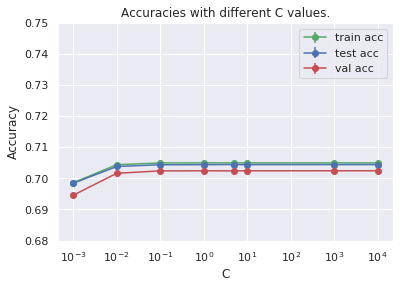

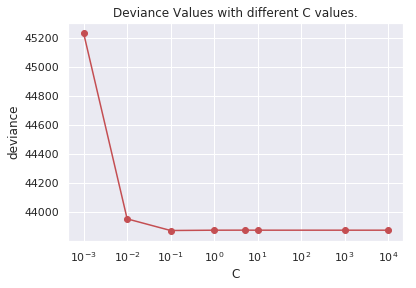

In [35]:
plot_accuracies(results)

1. [x] Select model evaluation crieria. - Accuracy Score + Deviance
    - [x] ROC curve.
    - [x] AUC values.
2. [x] Model evaluation with GridSearch.
3. [x] Model Performance analysis.
4. [x] Model tunning with statistics.
    - [x] Model evaluation comparison.
    - [x] From scratch model backwards and forward selection.
5. [ ] Model Summary.

####  Select Best Model.

Fit a model with the best parameters.

In [36]:
# Results are already sorted by val_acc, then test acc and finally train acc.
best_opts = results[0][1]
print('Best options are {}'.format(best_opts))

Best options are {'penalty': 'l2', 'fit_intercept': True, 'c': 1000}


In [37]:
lr_model = get_clf(**best_opts)
lr_model.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = lr_model.predict(X_test.to_numpy())
print("Test Accuracy {:.4%}".format(accuracy_score(y_pred, y_test)))

Test Accuracy 70.2689%


####  Analysis using GridSearch

In [38]:
cs = [.001, .01, .1, 1, 5, 10, 1000, 10000]
parameters = {'penalty': ['l2'], 'C':cs, 'fit_intercept': [True]}
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
grid = GridSearchCV(model, parameters, cv=5)
grid.fit(X_train.to_numpy(), y_train.to_numpy())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 5, 10, 1000, 10000], 'fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
print('Best parameters found with GridSearch Function: {}'.format(grid.best_params_))

Best parameters found with GridSearch Function: {'C': 1, 'fit_intercept': True, 'penalty': 'l2'}


In [48]:
lr_model = grid.best_estimator_
lr_model.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = lr_model.predict(X_test.to_numpy())
y_pred_prob = lr_model.predict_proba(X_test.to_numpy())

print("Test Accuracy {:.4%}".format(accuracy_score(y_pred, y_test)))

Test Accuracy 70.2740%


We see that the best parameters coincide with the ones that we found.

In [49]:
# Store the model
filename = os.path.join(modelsdir, 'lr_scikit')
store_model(lr_model, filename)

#### Model Performance Analysis

In [50]:
# Lets analyze the terms more related to the different classes.
# Coefficients for the positive class
coef = lr_model.coef_[0]
cols =  X_train.columns
srted = np.argsort(coef)
# Pick top 10 coef. in descendent order
topi = srted[::-1][:10]
boti = srted[:10]
print('Successful Terms:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(cols[topi], coef[topi])))
print('\nFail Terms:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(cols[boti], coef[boti])))

Successful Terms:
staff_pick (2.32297)
main_category_design (2.0632)
main_category_dance (1.24814)
main_category_theater (1.24479)
main_category_comics (1.0772)
main_category_games (0.894455)
state_VT (0.823129)
main_category_film-&-video (0.655516)
state_NY (0.645477)
main_category_music (0.594329)

Fail Terms:
main_category_journalism (-1.22781)
duration_in_days_bin_(45.0, inf] (-0.82011)
state_MS (-0.754024)
state_SD (-0.658324)
main_category_crafts (-0.59617)
state_OK (-0.563957)
state_NE (-0.544305)
state_AL (-0.51755)
state_WV (-0.500643)
ln(goal_usd) (-0.49456)


Text(0.5, 257.44, 'Predicted label')

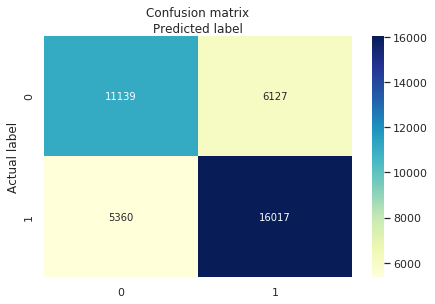

In [51]:
# Lets analyze the confusion matrix
cnf_matrix = confusion_matrix(y_test.to_numpy(), y_pred)

class_names=['fail','successful'] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [52]:
print("Accuracy Score: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Precision Score: {:.2%}".format(precision_score(y_test, y_pred)))
print("Recall Score: {:.2%} \n".format(recall_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy Score: 70.27%
Precision Score: 72.33%
Recall Score: 74.93% 

              precision    recall  f1-score   support

        fail       0.68      0.65      0.66     17266
  successful       0.72      0.75      0.74     21377

   micro avg       0.70      0.70      0.70     38643
   macro avg       0.70      0.70      0.70     38643
weighted avg       0.70      0.70      0.70     38643



In [53]:
# Lets take a look at the ROC curve.
ns_probs = [1 for _ in range(len(y_test))] # No skill predictor
# Keep only probabilities for Successful class
y_pred_prob_pos = y_pred_prob[:, 1]
# Calculate ROC scores
ns_roc = roc_auc_score(y_test, ns_probs)
model_roc = roc_auc_score(y_test, y_pred_prob_pos)
print("No Skill: ROC AUC = {:.3f}".format(ns_roc))
print("Logistic: ROC AUC = {:.3f}".format(model_roc))

# Calculate roc curves
ns_fpr, ns_tpr, thresholds = roc_curve(y_test, ns_probs)
model_fpr, model_tpr, thresholds = roc_curve(y_test, y_pred_prob_pos)

No Skill: ROC AUC = 0.500
Logistic: ROC AUC = 0.772


In [54]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test.to_numpy(), y_pred_prob_pos)

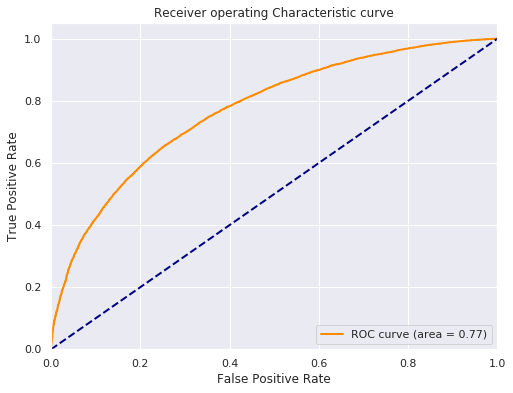

In [55]:
# Plot Roc Curves
fig = plt.figure(figsize=(8, 6))
plt.plot(model_fpr, model_tpr, color='darkorange',lw=2, label='ROC curve (area = {:.2f})'.format(model_roc))
plt.plot(ns_fpr, ns_tpr, color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

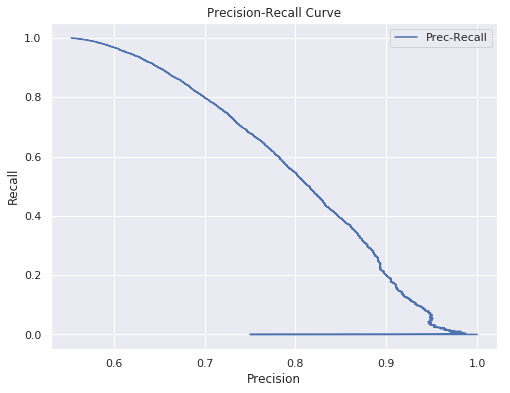

In [56]:
fig = plt.figure(figsize=(8, 6))
plt.plot(precision, recall, label='Prec-Recall')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

#### Recursive Feature Selection

In [57]:
len(lr_model.coef_[0])

77

In [43]:
#rfecv = RFECV(estimator=grid.best_estimator_, step=2, cv=StratifiedKFold(5))
#rfecv.fit(X_train.to_numpy(), y_train.to_numpy())

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=2, verbose=0)

Optimal number of features : 75


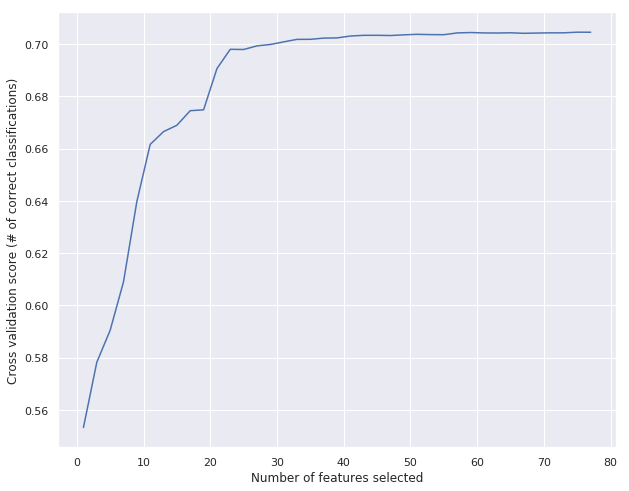

In [44]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(rfecv.support_) + 2, 2), rfecv.grid_scores_)
plt.show()

### 2.2.2 Statistics Analysis

For performing also a statistical analysis on the model and its parameters we will use the package stats.

In [58]:
def create_model_formula(target_var, x_vars, include_intercept=True):
    """Function for creating a formula.
    
    Args:
        target_var..........Dependent variable.
        x_vars..............List of independent variable.
        include_intercept...Bool to indicate whether to include or not the intercept.
    Returns:
        A string representing the formula to be passed.
    """
    if include_intercept:
        separator = " + "
        model_form = target_var + " ~ " + separator.join(x_vars)
    else:
        separator = " + "
        model_form = target_var + " ~ " + separator.join(x_vars) + " - 1"
    
    return model_form


def remove_vars_from_formula(formula, vars_to_remove):
    """Remove specific vars from the formula.
    
    Args:
        formula...........Formula to be applied in the model.
        args_to_remove....List of variables to remove from the formula.
    
    Returns:
        A string representing the formula.
    """
    separator = " - "
    model_form = formula + separator + separator.join(vars_to_remove)
    
    return model_form

In [59]:
df_model = pd.concat([y_train, X_train], axis=1)
df_model.rename(
    columns={'ln(goal_usd)': 'ln_goal_usd', 'main_category_film-&-video': 'main_category_film_video',
             #'duration_in_days_bin_(0.0, 29.0]': 'duration_in_days_low',
             'duration_in_days_bin_(29.0, 45.0]': 'duration_in_days_medium',
             'duration_in_days_bin_(45.0, inf]': 'duration_in_days_high',
             #'num_competitors_bin_(0.0, 10.0]': 'num_competitors_low',
             'num_competitors_bin_(10.0, 30.0]': 'num_competitors_medium',
             'num_competitors_bin_(30.0, inf]': 'num_competitors_high'},
    inplace=True
)

target_var = 'result'
x_vars = [col for col in df_model.columns if col != target_var]
model_form = create_model_formula(target_var, x_vars)

In [60]:
lr_stats = smf.glm(formula=model_form, data=df_model, family=sm.families.Binomial()).fit(method='lbfgs')

In [61]:
lr_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Generalized linear model
==========================================================================
Model:                  GLM                Method:           IRLS         
Link Function:          logit              AIC:              174985.1276  
Dependent Variable:     result             BIC:              -1671116.3957
Date:                   2020-07-09 13:55   Log-Likelihood:   -87415.      
No. Observations:       154571             LL-Null:          -1.0626e+05  
Df Model:               77                 Deviance:         1.7483e+05   
Df Residuals:           154493             Pearson chi2:     1.60e+05     
Converged:              1.0000             Scale:            1.0000       
No. Iterations:         2.0000                                            
--------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  0.0986   0.1136   0.8681 0.3854 -0.1240  0.3212
staff_pick                 2.3231   0.0258  89.8869 0.0000  2.2724  2.3737
ln_goal_usd               -0.4948   0.0065 -76.1900 0.0000 -0.5076 -0.4821
month_launch              -0.0258   0.0058  -4.4361 0.0000 -0.0371 -0.0144
main_category_comics       1.0802   0.0375  28.7718 0.0000  1.0067  1.1538
main_category_crafts      -0.5949   0.0429 -13.8566 0.0000 -0.6790 -0.5107
main_category_dance        1.2541   0.0646  19.4030 0.0000  1.1275  1.3808
main_category_design       2.0681   0.0399  51.8272 0.0000  1.9899  2.1463
main_category_fashion     -0.2666   0.0293  -9.0851 0.0000 -0.3241 -0.2091
main_category_film_video   0.6581   0.0250  26.3543 0.0000  0.6091  0.7070
main_category_food        -0.0262   0.0300  -0.8754 0.3813 -0.0850  0.0325
main_category_games        0.8973   0.0277  32.3526 0.0000  0.8429  0.9517
main_category_journalism  -1.2290   0.0560 -21.9321 0.0000 -1.3388 -1.1192
main_category_music        0.5970   0.0240  24.8486 0.0000  0.5499  0.6441
main_category_photography -0.0469   0.0429  -1.0949 0.2735 -0.1309  0.0371
main_category_publishing  -0.2414   0.0248  -9.7369 0.0000 -0.2900 -0.1928
main_category_technology  -0.4269   0.0296 -14.4424 0.0000 -0.4848 -0.3689
main_category_theater      1.2489   0.0450  27.7676 0.0000  1.1607  1.3370
state_AL                  -0.5696   0.1332  -4.2754 0.0000 -0.8308 -0.3085
state_AR                  -0.5413   0.1445  -3.7454 0.0002 -0.8246 -0.2581
state_AZ                  -0.2904   0.1184  -2.4523 0.0142 -0.5225 -0.0583
state_CA                   0.5295   0.1137   4.6562 0.0000  0.3066  0.7525
state_CO                   0.0105   0.1171   0.0900 0.9283 -0.2190  0.2401
state_CT                  -0.0907   0.1266  -0.7163 0.4738 -0.3389  0.1575
state_DC                   0.1480   0.1247   1.1869 0.2353 -0.0964  0.3923
state_DE                  -0.0635   0.1638  -0.3875 0.6984 -0.3846  0.2576
state_FL                  -0.4850   0.1146  -4.2338 0.0000 -0.7096 -0.2605
state_GA                  -0.4787   0.1164  -4.1127 0.0000 -0.7068 -0.2506
state_HI                  -0.0452   0.1391  -0.3246 0.7455 -0.3179  0.2275
state_IA                  -0.2448   0.1369  -1.7879 0.0738 -0.5131  0.0236
state_ID                  -0.2811   0.1350  -2.0816 0.0374 -0.5458 -0.0164
state_IL                   0.1611   0.1151   1.3991 0.1618 -0.0646  0.3867
state_IN                  -0.4858   0.1221  -3.9798 0.0001 -0.7250 -0.2465
state_KS                  -0.4777   0.1382  -3.4570 0.0005 -0.7486 -0.2069
state_KY                  -0.4278   0.1290  -3.3150 0.0009 -0.6807 -0.1748
state_LA                  -0.1582   0.1267  -1.2487 0.2118 -0.4064  0.0901
state_MA                   0.4544   0.1165   3.8995 0.0001  0.2260  0.6829
state_MD                  -0.2426   0.1210  -2.0042 0.0451 -0.4798 -0.0054
state_ME                   0.1847   0.1366   1.3522 0.1763 -0.0830  0.45

In [63]:
X_train_lr = X_train.rename(
    columns={'ln(goal_usd)': 'ln_goal_usd', 'main_category_film-&-video': 'main_category_film_video',
             #'duration_in_days_bin_(0.0, 29.0]': 'duration_in_days_low',
             'duration_in_days_bin_(29.0, 45.0]': 'duration_in_days_medium',
             'duration_in_days_bin_(45.0, inf]': 'duration_in_days_high',
             #'num_competitors_bin_(0.0, 10.0]': 'num_competitors_low',
             'num_competitors_bin_(10.0, 30.0]': 'num_competitors_medium',
             'num_competitors_bin_(30.0, inf]': 'num_competitors_high'}
)
X_test_lr = X_test.rename(
    columns={'ln(goal_usd)': 'ln_goal_usd', 'main_category_film-&-video': 'main_category_film_video',
             #'duration_in_days_bin_(0.0, 29.0]': 'duration_in_days_low',
             'duration_in_days_bin_(29.0, 45.0]': 'duration_in_days_medium',
             'duration_in_days_bin_(45.0, inf]': 'duration_in_days_high',
             #'num_competitors_bin_(0.0, 10.0]': 'num_competitors_low',
             'num_competitors_bin_(10.0, 30.0]': 'num_competitors_medium',
             'num_competitors_bin_(30.0, inf]': 'num_competitors_high'}
)

In [64]:
y_train_pred = lr_stats.predict(X_train_lr)
y_train_pred = y_train_pred.apply(lambda x: 1 if x > 0.5 else 0)
y_test_pred = lr_stats.predict(X_test_lr)
y_test_pred = y_test_pred.apply(lambda x: 1 if x > 0.5 else 0)

In [65]:
print('Accuracy on training data={:.10f}'.format(accuracy_score(y_train_pred, y_train)))
print('Accuracy on test data={:.10f}'.format(accuracy_score(y_test_pred, y_test)))

Accuracy on training data=0.7049123057
Accuracy on test data=0.7026628367


#### Stepwise selection

In [66]:
model_form = create_model_formula('result', '1')
lr_stats_null = smf.glm(formula=model_form, data=df_model, family=sm.families.Binomial()).fit(method='lbfgs')

In [67]:
# Lets drop variables until all variables are significant at a given cutoff (alpha).
alpha = .01

In [68]:
def backward_selection(data, response, X_test, y_test, max_iter=10, alpha=0.05, verbose=False):
    """Linear model designed for backwards selection.

    Args:
        data..........pandas DataFrame with all possible predictors and response.
        response......name of response column in data.
        X_test........Test set for computing accuracy of the model.
        y_test........Array of Test set actual labels.
        max_iter......Maximum number of removals.
        alpha.........Confidence threshold cutoff.

    Returns:
        model.........The final obtained model.
        removed_cols..Dict containing remove cols and their p-values.
        results.......Dict containing results on each interaction.
    """    
    x_vars = set(data.columns)
    x_vars.remove(response)
    removed_cols = [] # list of dicts containing {col_name: p_value}
    results = [] #list with dicts containing {formula: , accuracy_on_test: , aic}

    # Run model with all variables
    model_form = create_model_formula(response, x_vars)
    if verbose:
        print("Running model with formula: \n{}".format(model_form))
    lr_stats = smf.glm(formula=model_form, data=data, family=sm.families.Binomial()).fit(method='lbfgs')
    # Compute Accuracy
    y_test_pred = lr_stats.predict(X_test)
    y_test_pred = y_test_pred.apply(lambda x: 1 if x > 0.5 else 0)
    test_acc = accuracy_score(y_test_pred, y_test)
    results.append({'formula': model_form, 'test_accuracy': test_acc, 'aic': lr_stats.aic})
    
    p_values = lr_stats.pvalues.sort_values(ascending=False)
    if verbose:
            print("\nTest Accuracy: {}".format(test_acc))
            print("\nAIC: {}".format(lr_stats.aic))
            print("\nBiggest p-value: {}:{}".format(p_values.index[0], p_values[0]))
    
    while (p_values[0] > alpha) and (len(removed_cols) <= max_iter):
        
        removed_cols.append({p_values.index[0]: p_values[0]})
        print(removed_cols)
        model_form = remove_vars_from_formula(model_form, [p_values.index[0]])
        if verbose and len(removed_cols)>1:
            print("\n\nRunning model with formula: \n{}".format(model_form))
        
        lr_stats = smf.glm(formula=model_form, data=data, family=sm.families.Binomial()).fit(method='lbfgs')
        y_test_pred = lr_stats.predict(X_test)
        y_test_pred = y_test_pred.apply(lambda x: 1 if x > 0.5 else 0)
        test_acc = accuracy_score(y_test_pred, y_test)
        results.append({'formula': model_form, 'test_accuracy': test_acc, 'aic': lr_stats.aic})
        if verbose:
            print("\nTest Accuracy: {}".format(test_acc))
            print("\nAIC: {}".format(lr_stats.aic))
            print("\nBiggest p-value: {}:{}".format(p_values.index[0], p_values[0]))
        
        p_values = lr_stats.pvalues.sort_values(ascending=False)
        
    return lr_stats, removed_cols, results

In [69]:
lr_stats, removed_cols, results = backward_selection(df_model, target_var, X_test_lr, y_test,
                                                     alpha=alpha, max_iter = 100, verbose=True)

Running model with formula: 
result ~ state_PA + num_competitors_medium + weekday_launch_Wednesday + state_AR + duration_in_days_medium + state_IA + state_GA + main_category_games + state_NY + state_MN + state_NH + state_VT + state_AZ + state_RI + state_WI + state_NM + weekday_launch_Friday + state_MA + state_CT + main_category_journalism + state_MO + state_DE + state_MI + state_NE + main_category_technology + main_category_design + state_SD + main_category_publishing + state_WV + main_category_photography + main_category_comics + state_KS + weekday_launch_Sunday + state_MT + state_KY + state_CA + state_FL + state_NC + ln_goal_usd + state_MD + state_LA + state_IN + main_category_fashion + month_launch + state_OH + state_ND + state_HI + state_SC + state_MS + state_ME + main_category_crafts + state_IL + state_AL + duration_in_days_high + state_OR + main_category_dance + state_OK + main_category_food + staff_pick + state_CO + num_competitors_high + state_TN + main_category_film_video + st


Test Accuracy: 0.7027922262764278

AIC: 174975.37985742744

Biggest p-value: main_category_photography:0.3751194295353162
[{'state_PA': 0.9528329798566272}, {'state_CO': 0.929942853551981}, {'state_DE': 0.5598083904086186}, {'state_HI': 0.5612501253643905}, {'main_category_food': 0.3784944038595657}, {'main_category_photography': 0.3751194295353162}, {'state_TN': 0.3157134582094925}]


Running model with formula: 
result ~ state_PA + num_competitors_medium + weekday_launch_Wednesday + state_AR + duration_in_days_medium + state_IA + state_GA + main_category_games + state_NY + state_MN + state_NH + state_VT + state_AZ + state_RI + state_WI + state_NM + weekday_launch_Friday + state_MA + state_CT + main_category_journalism + state_MO + state_DE + state_MI + state_NE + main_category_technology + main_category_design + state_SD + main_category_publishing + state_WV + main_category_photography + main_category_comics + state_KS + weekday_launch_Sunday + state_MT + state_KY + state_CA + state


Test Accuracy: 0.7027663483683979

AIC: 174975.35593097485

Biggest p-value: state_CT:0.07692199051347341
[{'state_PA': 0.9528329798566272}, {'state_CO': 0.929942853551981}, {'state_DE': 0.5598083904086186}, {'state_HI': 0.5612501253643905}, {'main_category_food': 0.3784944038595657}, {'main_category_photography': 0.3751194295353162}, {'state_TN': 0.3157134582094925}, {'weekday_launch_Thursday': 0.23427266377189604}, {'state_NH': 0.19404639434197435}, {'state_WY': 0.09893012002168959}, {'state_CT': 0.07692199051347341}, {'state_NM': 0.07444161914755774}]


Running model with formula: 
result ~ state_PA + num_competitors_medium + weekday_launch_Wednesday + state_AR + duration_in_days_medium + state_IA + state_GA + main_category_games + state_NY + state_MN + state_NH + state_VT + state_AZ + state_RI + state_WI + state_NM + weekday_launch_Friday + state_MA + state_CT + main_category_journalism + state_MO + state_DE + state_MI + state_NE + main_category_technology + main_category_design +


Test Accuracy: 0.7026110809202184

AIC: 174990.974220435

Biggest p-value: weekday_launch_Wednesday:0.012342363253766116


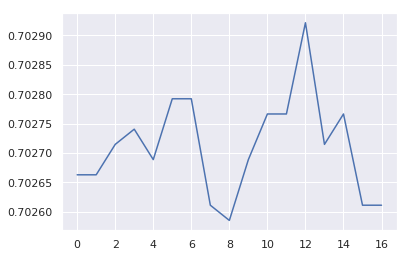

In [70]:
accs = [result['test_accuracy'] for result in results]
plt.plot(range(len(accs)), accs)

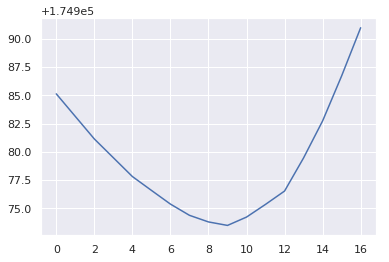

In [71]:
aic = [result['aic'] for result in results]
plt.plot(range(len(aic)), aic)

#### Model Performance Analysis

In [72]:
# Lets analyze the terms more related to the different classes.
# Coefficients for the positive class
coef_pr = lr_stats.params
cols_pr =  lr_stats.params.index
srted_pr = np.argsort(coef_pr)
# Pick top 10 coef. in descendent order
topi_pr = srted_pr[::-1][:10]
boti_pr = srted_pr[:10]
print('Successful Terms:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(cols_pr[topi_pr], coef_pr[topi_pr])))
print('\nFail Terms:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(cols[boti_pr], coef[boti_pr])))

Successful Terms:
staff_pick (2.32269)
main_category_design (2.08738)
main_category_dance (1.26821)
main_category_theater (1.26381)
main_category_comics (1.09591)
main_category_games (0.914243)
state_VT (0.742331)
main_category_film_video (0.672745)
main_category_music (0.611791)
state_NY (0.557587)

Fail Terms:
main_category_technology (-0.429075)
state_MS (-0.754024)
state_NE (-0.544305)
state_CO (0.0603189)
state_NM (-0.0784058)
state_AR (-0.487886)
state_ND (-0.402155)
state_DC (0.197418)
state_MT (0.347522)
month_launch (-0.02576)


Text(0.5, 257.44, 'Predicted label')

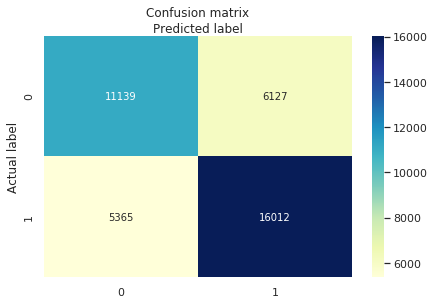

In [73]:
y_test_pred_prob_pr = lr_stats.predict(X_test_lr)
y_test_pred_pr = y_test_pred_prob_pr.apply(lambda x: 1 if x > 0.5 else 0)
# Lets analyze the confusion matrix
cnf_matrix_pr = confusion_matrix(y_test.to_numpy(), y_test_pred_pr)

class_names=['fail','successful'] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_pr), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [74]:
print("Accuracy Score: {:.2%}".format(accuracy_score(y_test, y_test_pred_pr)))
print("Precision Score: {:.2%}".format(precision_score(y_test, y_test_pred_pr)))
print("Recall Score: {:.2%} \n".format(recall_score(y_test, y_test_pred_pr)))
print(classification_report(y_test, y_test_pred_pr, target_names=class_names))

Accuracy Score: 70.26%
Precision Score: 72.32%
Recall Score: 74.90% 

              precision    recall  f1-score   support

        fail       0.67      0.65      0.66     17266
  successful       0.72      0.75      0.74     21377

   micro avg       0.70      0.70      0.70     38643
   macro avg       0.70      0.70      0.70     38643
weighted avg       0.70      0.70      0.70     38643



In [75]:
# Lets take a look at the ROC curve.
ns_probs = [1 for _ in range(len(y_test))] # No skill predictor
# Calculate ROC scores
ns_roc_pr = roc_auc_score(y_test, ns_probs)
model_roc_pr = roc_auc_score(y_test, y_test_pred_prob_pr)
print("No Skill: ROC AUC = {:.3f}".format(ns_roc))
print("Logistic Prunned: ROC AUC = {:.3f}".format(model_roc_pr))

No Skill: ROC AUC = 0.500
Logistic Prunned: ROC AUC = 0.772


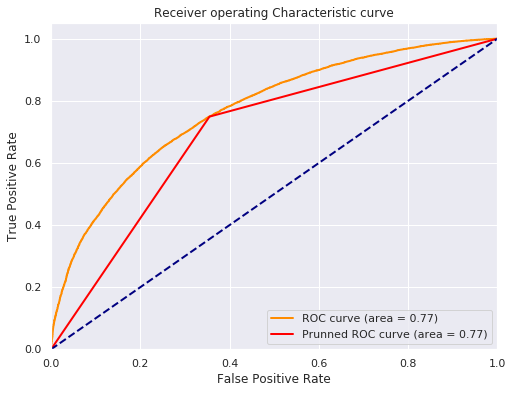

In [76]:
# Calculate roc curves
model_fpr_pr, model_tpr_pr, thresholds_pr = roc_curve(y_test, y_test_pred_pr)

# Calculate precision-recall curve
precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_test.to_numpy(), y_test_pred_prob_pr)

# Plot Roc Curves
fig = plt.figure(figsize=(8, 6))
plt.plot(model_fpr, model_tpr, color='darkorange',lw=2, label='ROC curve (area = {:.2f})'.format(model_roc))
plt.plot(model_fpr_pr, model_tpr_pr, color='red',lw=2, label='Prunned ROC curve (area = {:.2f})'.format(model_roc_pr))
plt.plot(ns_fpr, ns_tpr, color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

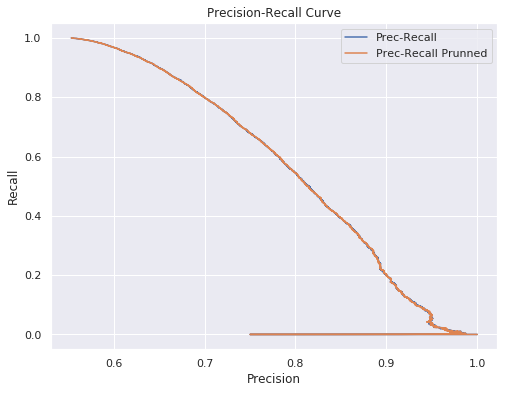

In [77]:
fig = plt.figure(figsize=(8, 6))
plt.plot(precision, recall, label='Prec-Recall')
plt.plot(precision_pr, recall_pr, label='Prec-Recall Prunned')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [78]:
filename = os.path.join(modelsdir, 'lr_stats')
store_model(lr_stats, filename)

### 2.3 Random Forest

We will perform a classifier using Random Forest. It is important to notice that a Random Forest implements several decision trees and ensembles them. In a classification task, each tree will make a classification, and the random forest final classification will be the the one with the highest mode.

First of all we will perform a basic Random Forest with default values to have a threshold accuracy value.

Then we will perform a cross-validation seeking for the best options for the random forest in terms of a balance between computing cost vs precision. We will perform this search both using an evaluation from scratch and using the gridsearch provided by the scikit package.

#### 2.3.1 Naive Log. Regression.

Perform a simple Random Forest to obtain an accuracy threshold.

In [13]:
rf_scikit = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scikit.fit(X_train, y_train)

y_test_pred = rf_scikit.predict(X_test)
y_train_pred = rf_scikit.predict(X_train)
print('Accuracy on training data={:.10f}'.format(accuracy_score(y_train_pred, y_train)))
print('Accuracy on test data={:.10f}'.format(accuracy_score(y_test_pred, y_test)))

Accuracy on training data=0.9796404241
Accuracy on test data=0.6789327951


We see that it clearly overfits.

We will perform Cross-validation to avoid the overfitting.

#### 2.3.2 Model Tunning

Lets analyse the different combinations of options for finding the best parameter configuration for the model.

In [17]:
# Creates a LogsticRegression object.
def get_clf_rf(random_state=42, **kwds):
    """Function for creating a Random Forest object.
    
    Args:
        random_state...RandomState instance.
        
    Returns:
        A Random Forest Classifier.
    """
    return RandomForestClassifier(random_state=random_state, **kwds)


def do_cross_validation_rf(X, y, X_val, y_val, n_folds=5, verbose=False, random_state=42, **kwds):
    """Perform a cross-validation accuracy.
    
    Args:
        X.....................Training set matrix without the y value.
        y.....................Class value for the training set.
        X_val.................Validation set matrix without the y value.
        y_val.................Class value for the validation set.
        n_folds...............Number of folds to be performed by the cross-validation.
        verbose...............Whether to print mid-results.
        random_state..........RandomState instance.
        **kwds................Other keyword arguments for the model.
    
    Returns:
        Tuple containing accuracies and SD for the train sets, test sets and validation sets.
    """
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    val_accuracies = []
    train_accuracies = []
    test_accuracies = []
    
    for foldi, (train_ind, test_ind) in enumerate(cv.split(X, y)):
        # Create Classification Model
        model = get_clf_rf(random_state=random_state, **kwds)
        # Fit model
        model.fit(X[train_ind, :], y[train_ind])
        # Perform accuracy on train set
        train_accuracies.append(accuracy_score(model.predict(X[train_ind]), y[train_ind]))
        # Predict on test set and perform accuracy
        acc = accuracy_score(y[test_ind], model.predict(X[test_ind, :]))
        test_accuracies.append(acc)
        # Predict on validation set and perform accuracy.
        val_accuracies.append(accuracy_score(y_val, model.predict(X_val)))
        if verbose:
            print('fold %d test accuracy=%.4g' % (foldi, acc))

    return (np.mean(test_accuracies), np.std(test_accuracies) / math.sqrt(n_folds),
            np.mean(train_accuracies), np.std(train_accuracies) / math.sqrt(n_folds),
            np.mean(val_accuracies), np.std(val_accuracies) / math.sqrt(n_folds)
           )


def print_results(results):
    print('test accuracy=%.4f (%.2f) train accuracy=%.4f (%.2f) validation accuracy=%.4f (%.2f)' % results)

    
def generate_all_opts_rf():
    """
    Enumerate all possible classifier settings and compute.
    """
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 25)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    #option_iter = product(penalty, fit_intercept)
    #return argnames, option_iter
    return random_grid

def eval_all_combinations(X_train, y_train, X_test, y_test, n_folds=3, verbose=False, **kwds):
    """Evaluate all combinations of options.
    """
    results = []
    random_grid = generate_all_opts_rf()
    # Create base model to tune
    rf = get_clf_rf()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=n_folds,
                                   verbose=2, random_state=42, n_jobs=None)
    rf_random.fit(X_train, y_train)
    
    return rf_random

In [18]:
results = eval_all_combinations(X_train, y_train, X_test, y_test, verbose=False)
#best_opts = results[0][1]
#print("Best options are {} with accuracy={:.2%}".format(results[0][1], results[0

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=835, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=835, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=10.5min
[CV] n_estimators=835, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min remaining:    0.0s


[CV]  n_estimators=835, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=13.6min
[CV] n_estimators=835, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 


KeyboardInterrupt: 

In [ ]:
#print("eval comb: {}".format(kwds))
        accs = do_cross_validation_rf(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(),
                                      y_test.to_numpy(), n_folds=n_folds, verbose=verbose, **kwds)
        opts = kwds.copy()
        results.append((accs, opts))
    results_sorted = sorted(results, key=lambda x: (-x[0][4], -x[0][0], -x[0][2]))

    argnames, option_iter = generate_all_opts()
    for options in option_iter:
        opts = {name: opt for name, opt in zip(argnames, options)}
        accs = do_cross_validation(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(),
                                      y_test.to_numpy(), n_folds=n_folds, verbose=verbose, **opts)
        results.append((accs, opts))
    results_sorted = sorted(results, key=lambda x: (-x[0][4], x[0][6], -x[0][0], -x[0][2]))
    return results_sorted


In [ ]:
results = eval_all_combinations(X_train, y_train, X_test, y_test, verbose=False)
best_opts = results[0][1]
print("Best options are {} with accuracy={:.2%}".format(results[0][1], results[0][0][4]))

In [ ]:
# Find the best c value
cs = [.001, .01, .1, 1, 5, 10, 1000, 10000]
results = eval_all_combinations(X_train, y_train, X_test, y_test, verbose=False,
                                cs=cs, **best_opts)

def plot_accuracies(results):
    """Plot accuracies for the different c values.
    """
    #Sort results according to c values
    results = sorted(results, key=lambda x: (x[1]['c']))
    accs = [result[0] for result in results]
    opts = [result[1] for result in results]
    cs = [opt['c'] for opt in opts]
    test_accs = [acc[0] for acc in accs]
    test_sd = [acc[1] for acc in accs]
    train_accs = [acc[2] for acc in accs]
    train_sd = [acc[3] for acc in accs]
    val_accs = [acc[4] for acc in accs]
    val_sd = [acc[5] for acc in accs]
    dev = [acc[6] for acc in accs]
    dev_sd = [acc[7] for acc in accs]
    
    # plot accuracies
    plt.figure()
    plt.errorbar(cs, train_accs, fmt='go-', label='train acc', yerr=train_sd)
    plt.errorbar(cs, test_accs, fmt='bo-', label='test acc', yerr=test_sd)
    plt.errorbar(cs, val_accs, fmt='ro-', label='val acc', yerr=val_sd)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.title("Accuracies with different C values.")
    plt.ylim([0.68, 0.75])
    plt.legend()
    plt.show()
    # plot deviance values
    plt.figure()
    plt.errorbar(cs, dev, fmt='ro-', label='deviance vals', yerr=dev_sd)
    plt.xlabel('C')
    plt.ylabel('deviance')
    plt.xscale('log')
    plt.title("Deviance Values with different C values.")
    plt.show()